In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [2]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

batch_size = 64


In [3]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = idx[:split_point]
test_idx = idx[split_point:]


train_dataset = Subset(dataset, train_idx)

test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [4]:
train_dataset.dataset.label

tensor([ 7,  7,  7,  ..., 28,  3,  2], device='cuda:0')

In [5]:

num_epochs = 50


In [6]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = np.concatenate([indices[:start], indices[end:]])
        trainval_indices = indices[start:end]
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        learning_rate = 0.1
        hidden_dim = 128

        # Initialize model and transfer to GPU
        model = MoannaModel(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.3084, Train Acc=0.1294, Val Acc=0.1515, Test Acc=0.1637
Fold 1/5, Epoch 2: Train Loss=3.0342, Train Acc=0.1783, Val Acc=0.1776, Test Acc=0.1997
Fold 1/5, Epoch 3: Train Loss=2.8073, Train Acc=0.2472, Val Acc=0.2664, Test Acc=0.3261
Fold 1/5, Epoch 4: Train Loss=2.5656, Train Acc=0.3184, Val Acc=0.3099, Test Acc=0.3807
Fold 1/5, Epoch 5: Train Loss=2.3572, Train Acc=0.3765, Val Acc=0.3241, Test Acc=0.4119
Fold 1/5, Epoch 6: Train Loss=2.1685, Train Acc=0.4412, Val Acc=0.3952, Test Acc=0.5072
Fold 1/5, Epoch 7: Train Loss=2.0149, Train Acc=0.4902, Val Acc=0.4168, Test Acc=0.5557
Fold 1/5, Epoch 8: Train Loss=1.8742, Train Acc=0.5348, Val Acc=0.4189, Test Acc=0.5743
Fold 1/5, Epoch 9: Train Loss=1.7247, Train Acc=0.5791, Val Acc=0.4368, Test Acc=0.6189
Fold 1/5, Epoch 10: Train Loss=1.6111, Train Acc=0.6066, Val Acc=0.4525, Test Acc=0.6488
Fold 1/5, Epoch 11: Train Loss=1.4995, Train Acc=0.6429, Val Acc=0.4517, Test Acc=0.6745
Fold 1/

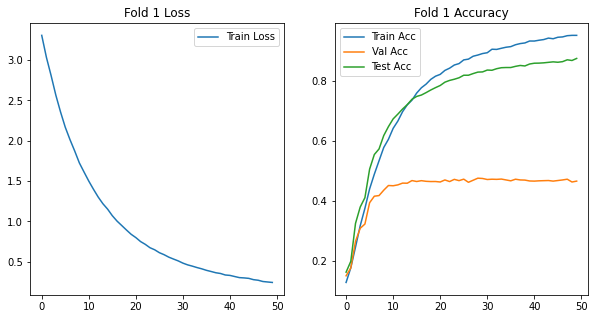

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.3201, Train Acc=0.1202, Val Acc=0.1751, Test Acc=0.1919
Fold 2/5, Epoch 2: Train Loss=3.0426, Train Acc=0.1738, Val Acc=0.2021, Test Acc=0.2196
Fold 2/5, Epoch 3: Train Loss=2.8161, Train Acc=0.2431, Val Acc=0.2557, Test Acc=0.2837
Fold 2/5, Epoch 4: Train Loss=2.5860, Train Acc=0.3154, Val Acc=0.3140, Test Acc=0.3641
Fold 2/5, Epoch 5: Train Loss=2.3652, Train Acc=0.3816, Val Acc=0.3382, Test Acc=0.4197
Fold 2/5, Epoch 6: Train Loss=2.1853, Train Acc=0.4404, Val Acc=0.3892, Test Acc=0.5030
Fold 2/5, Epoch 7: Train Loss=2.0260, Train Acc=0.4936, Val Acc=0.4017, Test Acc=0.5564
Fold 2/5, Epoch 8: Train Loss=1.8822, Train Acc=0.5355, Val Acc=0.4188, Test Acc=0.5850
Fold 2/5, Epoch 9: Train Loss=1.7490, Train Acc=0.5704, Val Acc=0.4339, Test Acc=0.6212
Fold 2/5, Epoch 10: Train Loss=1.6209, Train Acc=0.6076, Val Acc=0.4302, Test Acc=0.6433
Fold 2/5, Epoch 11: Train Loss=1.5160, Train Acc=0.6406, Val Acc=0.4417, Test Acc=0.6667
Fold 2/

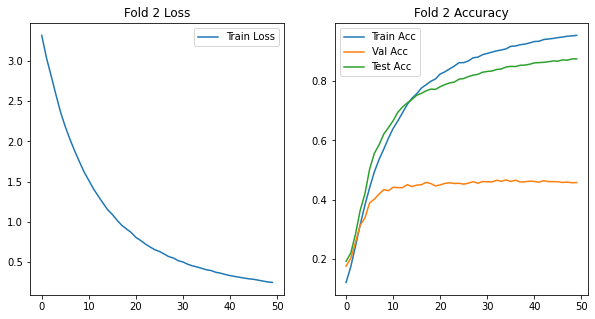

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.3133, Train Acc=0.1257, Val Acc=0.1698, Test Acc=0.1757
Fold 3/5, Epoch 2: Train Loss=3.0340, Train Acc=0.1771, Val Acc=0.2030, Test Acc=0.2261
Fold 3/5, Epoch 3: Train Loss=2.7951, Train Acc=0.2520, Val Acc=0.2842, Test Acc=0.3312
Fold 3/5, Epoch 4: Train Loss=2.5594, Train Acc=0.3235, Val Acc=0.3014, Test Acc=0.3765
Fold 3/5, Epoch 5: Train Loss=2.3514, Train Acc=0.3783, Val Acc=0.3218, Test Acc=0.4149
Fold 3/5, Epoch 6: Train Loss=2.1598, Train Acc=0.4399, Val Acc=0.3929, Test Acc=0.4960
Fold 3/5, Epoch 7: Train Loss=1.9966, Train Acc=0.5015, Val Acc=0.4224, Test Acc=0.5678
Fold 3/5, Epoch 8: Train Loss=1.8418, Train Acc=0.5471, Val Acc=0.4354, Test Acc=0.5915
Fold 3/5, Epoch 9: Train Loss=1.7114, Train Acc=0.5857, Val Acc=0.4310, Test Acc=0.6107
Fold 3/5, Epoch 10: Train Loss=1.5925, Train Acc=0.6195, Val Acc=0.4396, Test Acc=0.6358
Fold 3/5, Epoch 11: Train Loss=1.4780, Train Acc=0.6475, Val Acc=0.4468, Test Acc=0.6609
Fold 3/

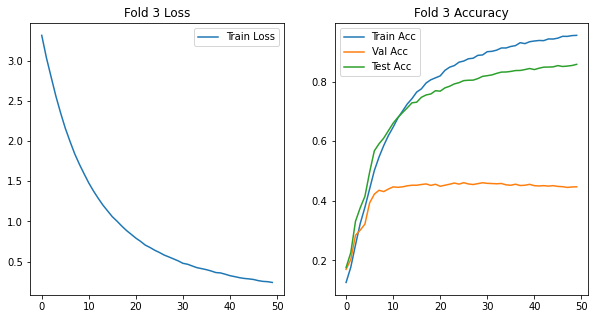

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.3148, Train Acc=0.1203, Val Acc=0.1600, Test Acc=0.1702
Fold 4/5, Epoch 2: Train Loss=3.0376, Train Acc=0.1761, Val Acc=0.1821, Test Acc=0.2147
Fold 4/5, Epoch 3: Train Loss=2.8021, Train Acc=0.2466, Val Acc=0.2899, Test Acc=0.3234
Fold 4/5, Epoch 4: Train Loss=2.5699, Train Acc=0.3240, Val Acc=0.3200, Test Acc=0.3661
Fold 4/5, Epoch 5: Train Loss=2.3530, Train Acc=0.3784, Val Acc=0.3590, Test Acc=0.4445
Fold 4/5, Epoch 6: Train Loss=2.1723, Train Acc=0.4478, Val Acc=0.3896, Test Acc=0.5027
Fold 4/5, Epoch 7: Train Loss=2.0066, Train Acc=0.5000, Val Acc=0.4053, Test Acc=0.5392
Fold 4/5, Epoch 8: Train Loss=1.8663, Train Acc=0.5409, Val Acc=0.4212, Test Acc=0.5757
Fold 4/5, Epoch 9: Train Loss=1.7268, Train Acc=0.5790, Val Acc=0.4364, Test Acc=0.6076
Fold 4/5, Epoch 10: Train Loss=1.6119, Train Acc=0.6173, Val Acc=0.4437, Test Acc=0.6391
Fold 4/5, Epoch 11: Train Loss=1.5021, Train Acc=0.6490, Val Acc=0.4411, Test Acc=0.6615
Fold 4/

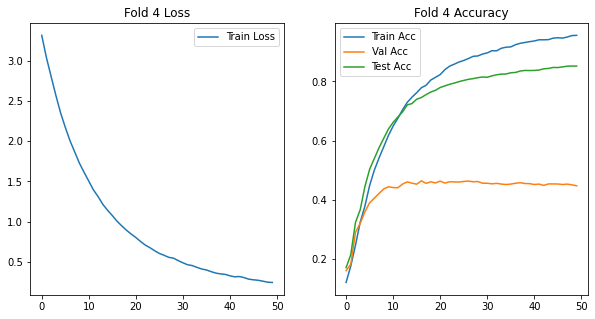

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.3176, Train Acc=0.1299, Val Acc=0.1906, Test Acc=0.2030
Fold 5/5, Epoch 2: Train Loss=3.0384, Train Acc=0.1809, Val Acc=0.2129, Test Acc=0.2427
Fold 5/5, Epoch 3: Train Loss=2.8044, Train Acc=0.2526, Val Acc=0.2769, Test Acc=0.3257
Fold 5/5, Epoch 4: Train Loss=2.5631, Train Acc=0.3203, Val Acc=0.2944, Test Acc=0.3521
Fold 5/5, Epoch 5: Train Loss=2.3478, Train Acc=0.3711, Val Acc=0.3241, Test Acc=0.4130
Fold 5/5, Epoch 6: Train Loss=2.1609, Train Acc=0.4371, Val Acc=0.3841, Test Acc=0.4982
Fold 5/5, Epoch 7: Train Loss=2.0074, Train Acc=0.4968, Val Acc=0.4149, Test Acc=0.5424
Fold 5/5, Epoch 8: Train Loss=1.8509, Train Acc=0.5464, Val Acc=0.4227, Test Acc=0.5883
Fold 5/5, Epoch 9: Train Loss=1.7332, Train Acc=0.5802, Val Acc=0.4349, Test Acc=0.6212
Fold 5/5, Epoch 10: Train Loss=1.6054, Train Acc=0.6129, Val Acc=0.4445, Test Acc=0.6475
Fold 5/5, Epoch 11: Train Loss=1.4913, Train Acc=0.6461, Val Acc=0.4499, Test Acc=0.6771
Fold 5/

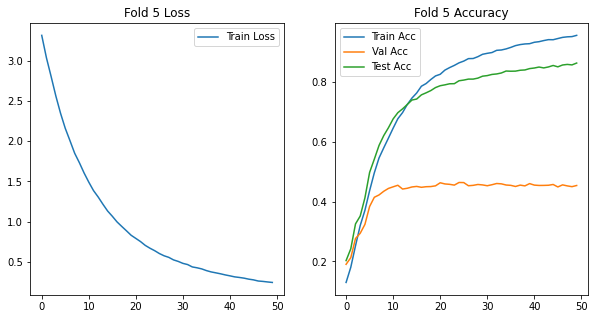

In [7]:

Model = k_fold_cross_validation(train_dataset.dataset, test_loader, 5, num_epochs, batch_size, device=device, shuffle=True)

In [8]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=12

In [9]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [10]:
for i in range(5):
    test_model(Model[i], test_loader)


Test Accuracy: 0.8760
Test Accuracy: 0.8757
Test Accuracy: 0.8585
Test Accuracy: 0.8516
Test Accuracy: 0.8639


In [11]:


# for inputs, labels in train_loader:
#     outputs = best_model(inputs)
#     print(torch.argmax(outputs, dim=1))
#     print(labels)